In [27]:
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import os 

# Parameters

In [28]:
#TODO Test and show results on Forest Cover Dataset 
dataset='ElectricDevices'

# Load Data

In [29]:
# Train Test Val Split
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x = train_x.reshape(-1,1,  train_x.shape[-2])
test_x = test_x.reshape(-1,1,  test_x.shape[-2])


In [30]:
print(test_y.shape)

(7711,)


In [31]:
enc1=pickle.load(open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','rb'))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))

In [32]:
full_x= np.vstack([train_x, test_x])
full_y= np.vstack([train_y, test_y])

In [33]:
# New Train/ Test Split with 0.33
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( full_x, full_y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.33, random_state=42)

# Model Training

In [34]:
#TODO Load Data and make this new
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(X_train.astype(np.float64),y_train.astype(np.int64))
test_dataset = UCRDataset(X_test.astype(np.float64),y_test.astype(np.int64))
val_dataset = UCRDataset(X_val.astype(np.float64),y_val.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=256,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=256,shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
model.eval()

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(1, 64, kernel_size=(1,)

In [35]:
#from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT
#exp_model=TSInsightPYT(model,(train_x.shape[-2],train_x.shape[-1]),(train_x,train_y), (test_x,test_y), autoencoder='cnn')


# Explanation Algo

In [36]:
from TSInterpret.InterpretabilityModels.TSInsight.CNN_PYT import ConvAutoencoder
from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT
#TODO make model decision according to val !
autoencoder= ConvAutoencoder(1)
autoencoder.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/TSInsightAutoencoder_cnn'))
exp_model=TSInsightPYT(model,(train_x.shape[-2],train_x.shape[-1]),(train_x,train_y), (test_x,test_y), autoencoder=autoencoder)

INFO - Provided Datasets are Tuples. Create a Default DataLoader.
Epoch: 0, Fine Tune Loss: 6.417, consits of 1.1772937774658203, 0.02637423388659954, 0.004953066818416119, 5.208116054534912
Epoch: 0, Fine Validation Loss: 7.766, consits of 2.5431013107299805, 0.013339596800506115, 0.001749119721353054, 5.208116054534912
Epoch: 1, Fine Tune Loss: 5.399, consits of 0.7682662010192871, 0.10928115993738174, 0.003174756420776248, 4.518661022186279
Epoch: 1, Fine Validation Loss: 6.793, consits of 2.067401885986328, 0.2035135179758072, 0.003100744215771556, 4.518661022186279
Epoch: 2, Fine Tune Loss: 6.255, consits of 2.076974630355835, 0.08072581142187119, 0.003414023434743285, 4.093662738800049
Epoch: 2, Fine Validation Loss: 6.372, consits of 2.0854763984680176, 0.18957798182964325, 0.0029409541748464108, 4.093662738800049
Epoch: 3, Fine Tune Loss: 8.184, consits of 0.6969503164291382, 3.703386068344116, 0.013383686542510986, 3.770275831222534
Epoch: 3, Fine Validation Loss: 5.964, consi

In [37]:
#from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT
#exp_model=TSInsightPYT(model,(shape[-2],shape[-1]),train_loader, test_loader, autoencoder='cnn')

In [38]:
# save model 
#torch.save(exp_model.autoencoder.state_dict(), f'../../ClassificationModels/models/{dataset}/TSInsightAutoencoder_cnn')

In [39]:
item=X_val[0].reshape(1,1,-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
#y_target= model(_item).detach().numpy()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

In [40]:
exp=exp_model.explain(item)

In [41]:
np.count_nonzero(item.flatten()-exp.flatten())

96

In [42]:
exp.shape

(1, 1, 96)

In [43]:
item.shape

(1, 1, 96)

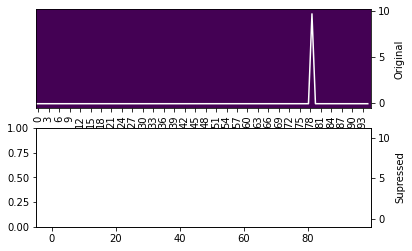

In [44]:
#TODO scale og plot
exp_model.plot(item, exp,all_in_one=False)

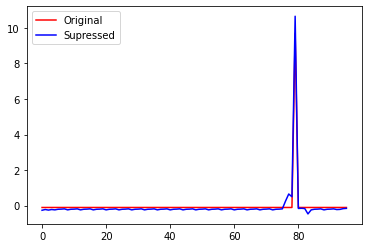

In [45]:
exp_model.plot(item, exp)

<AxesSubplot:>

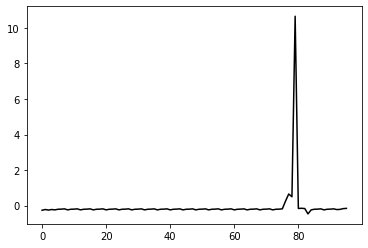

In [46]:
sns.lineplot(x=range(0,len(exp.reshape(-1))), y=exp.flatten(), color='black')